In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [54]:
# cargamos datos
train_data = pd.read_csv("./df_for_imputation.csv") # cargamos fichero
train_data.columns = train_data.columns.str.replace(' ', '_').str.lower()
# Cambiamos square_feet a metros cuadrados generando una nueva columna
train_data.head()

,host_response_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_since_in_days,first_review_in_days,entire_home/apt,private_room,shared_room,square_meters
0,100.0,2.0,2.0,28020.0,40.457202,-3.696404,2.0,1.0,1.0,2.0,...,10.0,10.0,2.0,0.590,398.0,335.0,0.0,1.0,0.0,84.467408
1,98.0,17.0,17.0,28013.0,40.416522,-3.712797,5.0,1.0,2.0,4.0,...,10.0,10.0,10.0,1.580,1329.0,539.0,1.0,0.0,0.0,51.784132
2,50.0,1.0,1.0,28010.0,40.432653,-3.699381,2.0,1.0,1.0,1.0,...,9.6,9.4,1.0,0.606,787.0,214.4,0.0,1.0,0.0,36.808169
3,100.0,9.0,9.0,28012.0,40.415627,-3.704847,2.0,2.0,1.0,1.0,...,10.0,9.0,9.0,5.450,2028.0,241.0,0.0,1.0,0.0,45.986985
4,100.0,3.0,3.0,28012.0,40.409603,-3.695018,2.0,1.0,1.0,1.0,...,9.6,9.4,3.0,0.606,779.0,535.6,1.0,0.0,0.0,47.027499


### Vamos a volver a mirar la correlación entre las variables

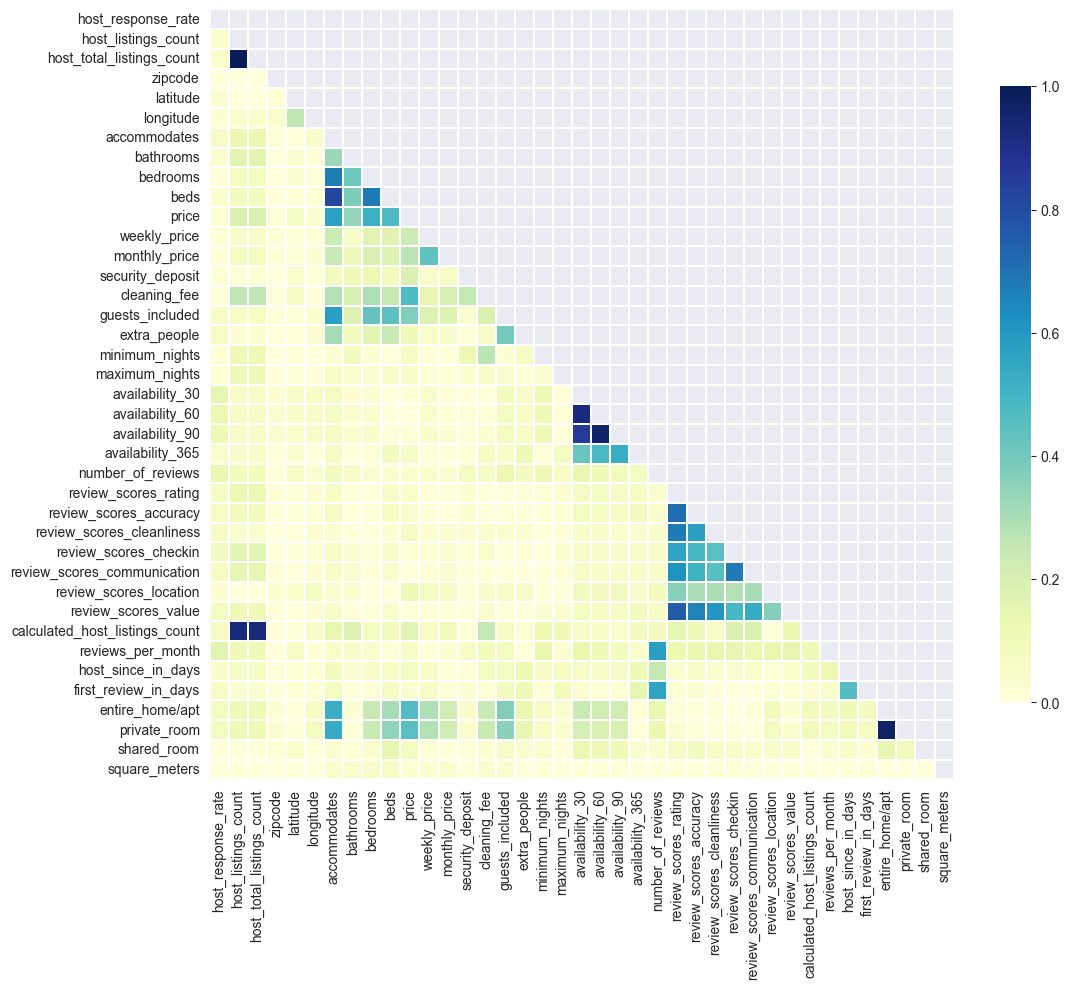

In [55]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train_data.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

#### Comparado con lo anterior, se ha perdido mucha correlación, por lo que no vamos a garantizar un buen modelo, lo ideal pudo haber sido integrar las variables de barrio

In [56]:
corr['price'].sort_values(ascending=False).head(40)

price                             1.000000
accommodates                      0.573318
bedrooms                          0.519318
beds                              0.473516
cleaning_fee                      0.470968
entire_home/apt                   0.467349
private_room                      0.450319
guests_included                   0.374465
bathrooms                         0.338361
monthly_price                     0.273183
weekly_price                      0.234020
security_deposit                  0.190039
host_listings_count               0.188614
host_total_listings_count         0.188498
calculated_host_listings_count    0.162649
review_scores_location            0.114870
extra_people                      0.107809
host_since_in_days                0.081722
shared_room                       0.081386
minimum_nights                    0.074161
availability_365                  0.067795
latitude                          0.067216
review_scores_cleanliness         0.064837
reviews_per

#### observamos que se perdio la correlación de precio con metros cuadrados, pero vamos a continuar

In [57]:
# Obtenemos la posición de la columna price en el dataframe
position_price = train_data.columns.tolist().index('price')
position_price

10

In [58]:
# Nos encontramos con variables nulas, no son muchas, pero las removemos de train

train_data.isna().mean()*100
train_data[train_data.isnull().any(axis=1)]
# removemos esas filas
train_data = train_data.dropna()
train_data[train_data.isnull().any(axis=1)]

,host_response_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_since_in_days,first_review_in_days,entire_home/apt,private_room,shared_room,square_meters


#### Vamos a revisar F score y mutual information score

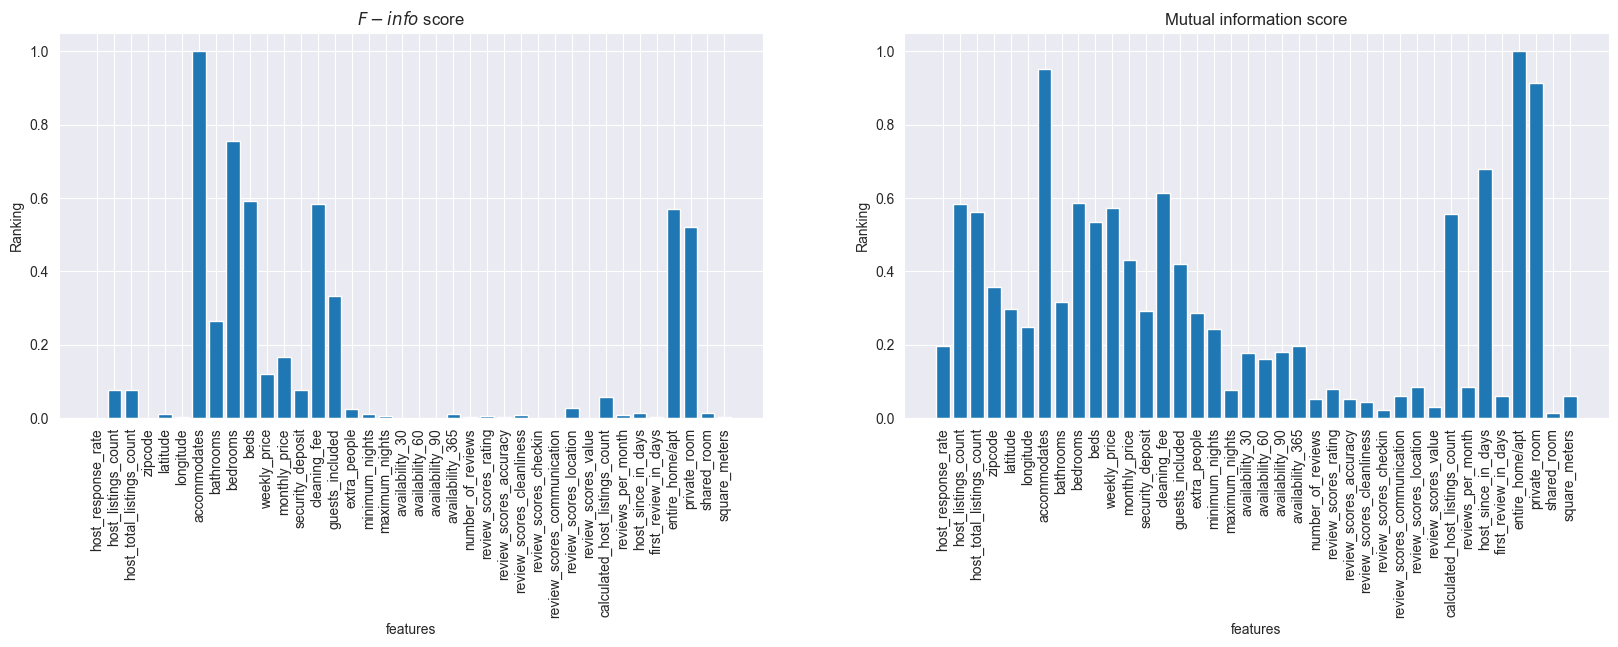

In [59]:
# convertimos el dataframe a numpy
data = train_data.values
data_restante = train_data.drop(columns='price').copy()

y = data[:,10]
X = data_restante.values
feature_names = data_restante.columns.tolist()
# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-info$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

#### Podemos observar que F score no nos da mucha información, mutual information score en cambio, nos muestra las dependencias de forma estadistica
#### Vamos a usar gridsearch con Lasso para observar mejor las variables, aquí vamos a usar todo lo que conocemos de train para observar las caracteristicas que nos acercan mejor a los resultados que esperaremos

Datos entrenamiento:  (7857, 38)
Datos test:  (2619, 38)
best mean cross-validation score: -1457.296
best parameters: {'alpha': 0.1}


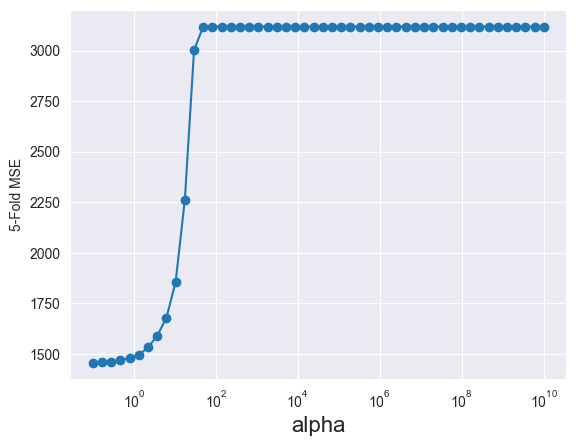

In [60]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,10,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()


In [61]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.43e+03
MSE Modelo Lasso (test) : 1.24e+03
RMSE Modelo Lasso (train): 37.9
RMSE Modelo Lasso (test) : 35.2
host_response_rate -1.2695209440618078
host_listings_count 5.814892138454093
host_total_listings_count 2.731989284280851
zipcode 0.0
latitude 1.2729884929832738
longitude -0.5764618233918836
accommodates 11.826105790466105
bathrooms 8.681332841368897
bedrooms 8.071949146924032
beds -1.371494139493025
weekly_price 0.2396389692632189
monthly_price 3.437982774162281
security_deposit 3.251420898789062
cleaning_fee 13.150441775322673
guests_included 3.0145021592377326
extra_people -4.244080846708641
minimum_nights -1.4408286430736168
maximum_nights -0.12373077249560574
availability_30 7.4582796460720475
availability_60 0.0
availability_90 -1.7597238948231946
availability_365 0.43098471075786243
number_of_reviews -2.66336601213051
review_scores_rating 3.187983998218701
review_scores_accuracy 1.2113484277007158
review_scores_cleanliness 1.0703656972154263
revie

In [62]:
train_data.describe()

,host_response_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_since_in_days,first_review_in_days,entire_home/apt,private_room,shared_room,square_meters
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,...,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,94.653510,9.817297,9.808209,28013.069967,40.420513,-3.697063,3.183753,1.249671,1.288603,1.985699,...,9.551742,9.217168,7.695399,1.859236,906.324998,405.430734,0.595647,0.389843,0.014509,58.100593
std,14.630137,27.768122,27.755549,115.424553,0.020083,0.023579,1.987149,0.590359,0.817986,1.525016,...,0.677369,0.851899,20.031543,1.748340,584.087464,386.255084,0.490790,0.487738,0.119583,22.418795
min,0.000000,0.000000,0.000000,20013.000000,40.331888,-3.822403,1.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,1.000000,0.020000,1.000000,0.000000,0.000000,0.000000,0.000000,0.743224
25%,94.652719,1.000000,1.000000,28005.000000,40.410071,-3.707752,2.000000,1.000000,1.000000,1.000000,...,9.000000,9.000000,1.000000,0.606000,430.000000,122.000000,0.000000,0.000000,0.000000,42.010737
50%,100.000000,2.000000,2.000000,28012.000000,40.418592,-3.701542,2.000000,1.000000,1.000000,1.200000,...,10.000000,9.000000,2.000000,1.300000,788.000000,314.000000,1.000000,0.000000,0.000000,53.382064
75%,100.000000,5.000000,5.000000,28015.000000,40.427802,-3.693801,4.000000,1.000000,2.000000,2.000000,...,10.000000,10.000000,4.000000,2.672500,1356.000000,557.000000,1.000000,1.000000,0.000000,71.405246
max,100.000000,265.000000,265.000000,28850.000000,40.514247,-3.573613,16.000000,8.000000,10.000000,16.000000,...,10.000000,10.000000,145.000000,17.210000,2883.000000,2519.000000,1.000000,1.000000,1.000000,250.001973


#### No son buenos resultados, pero sabemos que anteriormente bombardeamos train por medio de estimación de missing values sin tomar tantas medidas cautelares

# Usando arboles para selección de características

#### Vamos a probar con los arbolitos para ver que caracteristicas se nos dice que son las mas propensas a estimar el valor del precio que buscamos

Fitting 10 folds for each of 14 candidates, totalling 140 fits
best mean cross-validation score: 0.466
best parameters: {'max_depth': 5}


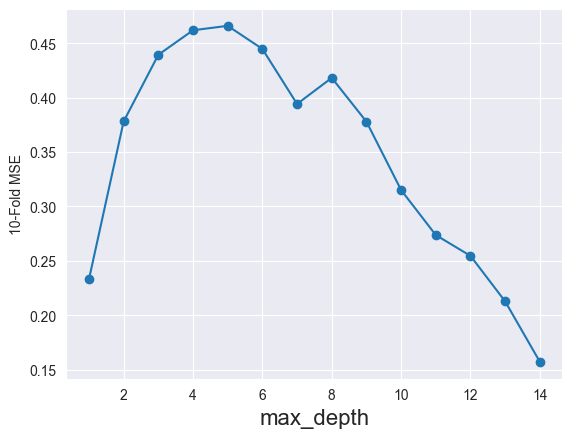

In [63]:
from sklearn.tree import DecisionTreeRegressor

# Tu código aquí
maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10, verbose=1)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [64]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

Train:  0.5930857469137222
Test:  0.49718737451318595


In [74]:
maxDepthOptimo = 6
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

Train:  0.6489280653946525
Test:  0.448683411099316


#### Se ven medio peores este asunto, por lo menos se observa una dispersión entre train y test con el valor optimo de 10 puntos, un volado practicamente nuestra predicción

#### Vamos a observar la importancia de las caracteristicas

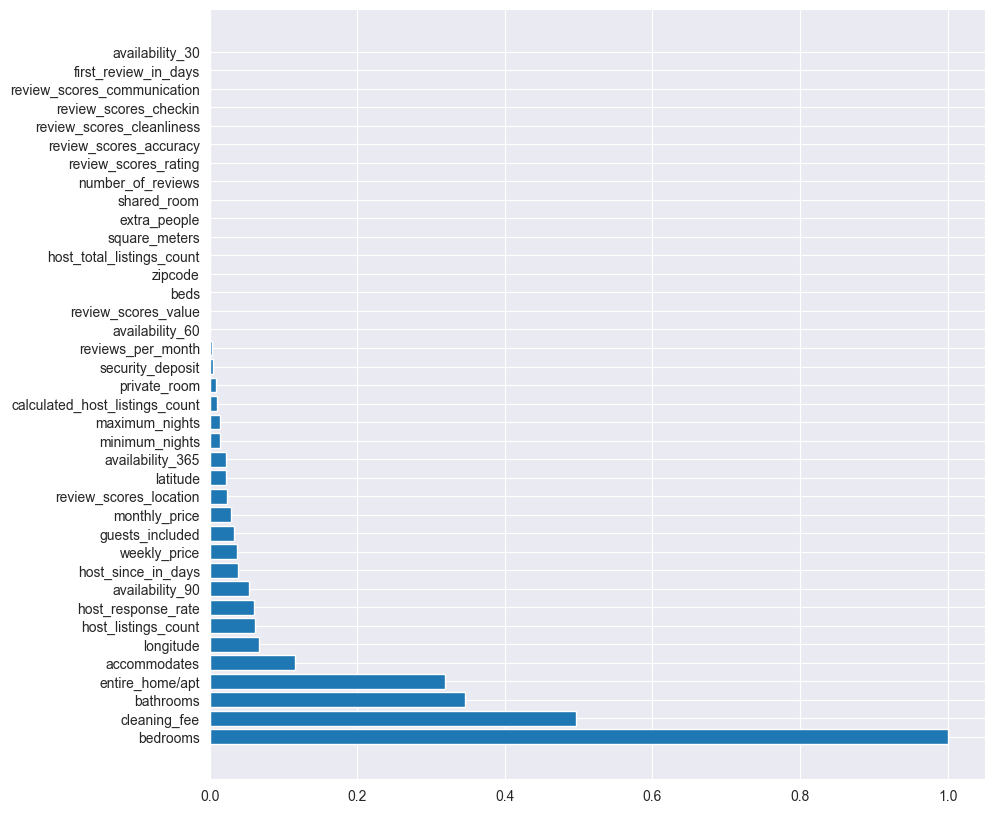

In [75]:
importances = treeModel.feature_importances_
importances = importances / np.max(importances)
feature_names = data_restante.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

#### Tenemos un estimador muy alto que es bedrooms, ok, es coherente, sin embargo es muy pesado y la diferencia con la otras variables es brutal, no podemos aceptar eso

# Vamos a hacer uso de Random forest ahora

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................................max_depth=1; total time=   0.5s
[CV] END ........................................max_depth=1; total time=   0.5s
[CV] END ........................................max_depth=1; total time=   0.5s
[CV] END ........................................max_depth=1; total time=   0.5s
[CV] END ........................................max_depth=1; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.9s
[CV] END ........................................max_depth=2; total time=   0.8s
[CV] END ........................................max_depth=2; total time=   0.7s
[CV] END ........................................max_depth=2; total time=   0.8s
[CV] END ........................................max_depth=2; total time=   0.8s
[CV] END ........................................max_depth=3; total time=   1.2s
[CV] END .......................................

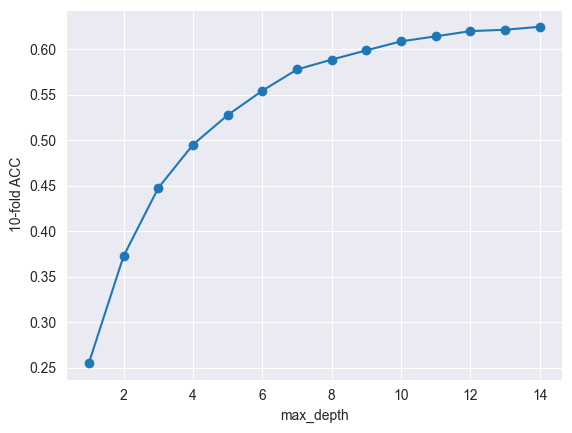

In [76]:
from sklearn.ensemble import RandomForestRegressor

# Tu código aquí
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [77]:
maxDepthOptimo = grid.best_params_['max_depth']
print(f'El max depth optimo es {maxDepthOptimo}')
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

El max depth optimo es 14
Train:  0.9146065934975173
Test:  0.6779537987470408


#### Mejoró bastante el asunto, vamos a probar con varios max_depth alrededor del optimo

In [80]:
maxDepthOptimo = 11
print(f'El max depth optimo es {maxDepthOptimo}')
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

El max depth optimo es 11
Train:  0.8608643682126892
Test:  0.6696913034536078


#### Nos quedamos con el max_depth optimo que nos da la estrategia, vamos a ver la importancia de las variables

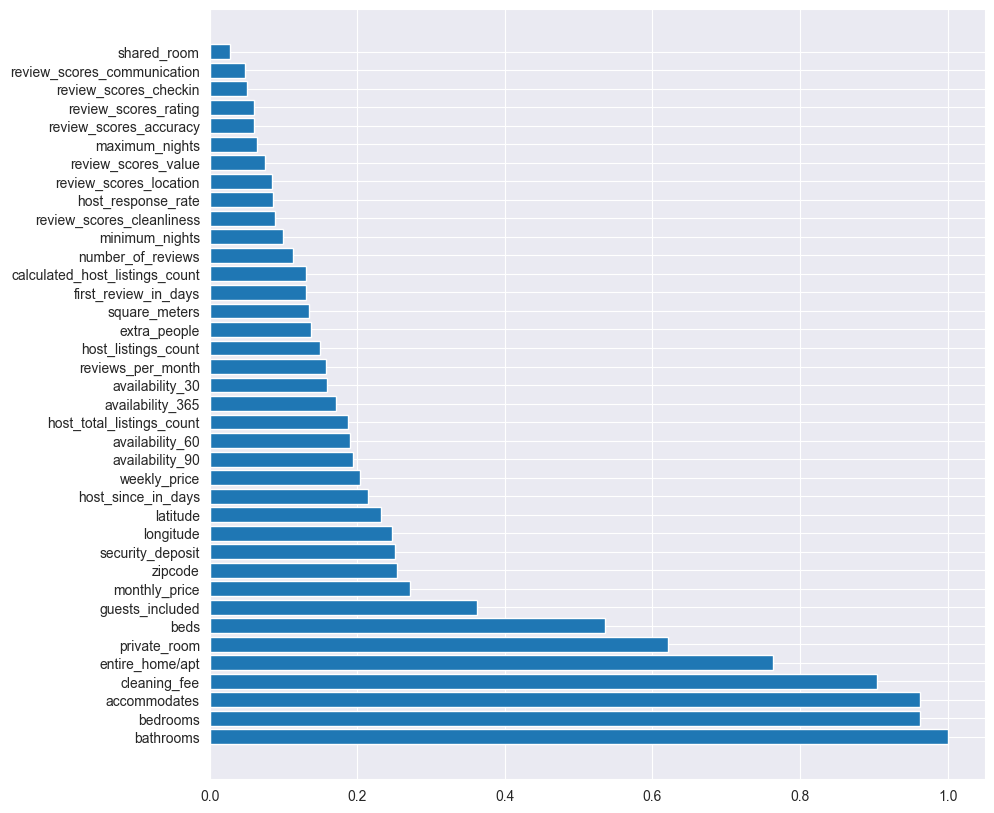

In [81]:
# Tu código aquí
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

#### Se observan varias variables con fuerte peso, esto nos puede ayudar incluso a descartar cualquiera de ellas, por ejemplo accommodates o bedrooms

# Probamos con Baggin regresor

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................base_estimator__max_depth=1; total time=   2.0s
[CV] END ........................base_estimator__max_depth=1; total time=   1.9s
[CV] END ........................base_estimator__max_depth=1; total time=   1.9s
[CV] END ........................base_estimator__max_depth=1; total time=   1.9s
[CV] END ........................base_estimator__max_depth=1; total time=   1.9s
[CV] END ........................base_estimator__max_depth=2; total time=   3.5s
[CV] END ........................base_estimator__max_depth=2; total time=   3.5s
[CV] END ........................base_estimator__max_depth=2; total time=   3.4s
[CV] END ........................base_estimator__max_depth=2; total time=   3.4s
[CV] END ........................base_estimator__max_depth=2; total time=   3.5s
[CV] END ........................base_estimator__max_depth=3; total time=   5.2s
[CV] END ........................base_estimator_

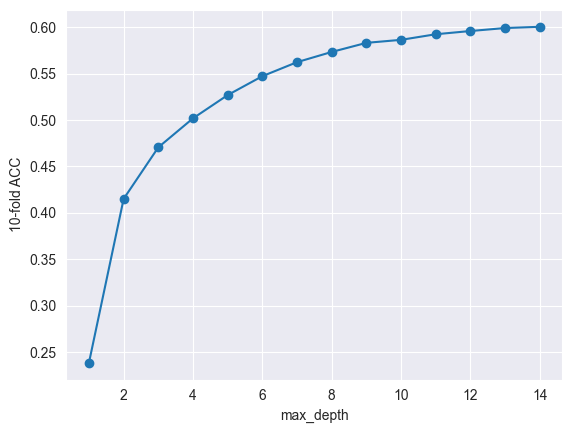

In [82]:
from sklearn.ensemble import BaggingRegressor

# Tu código aquí
maxDepth = range(1,15)
tuned_parameters = {'base_estimator__max_depth': maxDepth}

grid = GridSearchCV(BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=0, n_estimators=200), param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

#### Probamos el 11 como optimo

In [83]:
maxDepthOptimo = 11
bagModel = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=maxDepthOptimo),n_estimators=200,max_features=20)

bagModel.fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.8751336049502524
Test:  0.6784939452871454


In [84]:
importances = bagModel.base_estimator_.feature_importances_

# print the feature importances
print(importances)

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Podemos ver que nos da resultados similares, por lo que vamos a tomar la lista de variables que nos da random forest

In [85]:
feature_names[indices]

Index(['bathrooms', 'bedrooms', 'accommodates', 'cleaning_fee',
       'entire_home/apt', 'private_room', 'beds', 'guests_included',
       'monthly_price', 'zipcode', 'security_deposit', 'longitude', 'latitude',
       'host_since_in_days', 'weekly_price', 'availability_90',
       'availability_60', 'host_total_listings_count', 'availability_365',
       'availability_30', 'reviews_per_month', 'host_listings_count',
       'extra_people', 'square_meters', 'first_review_in_days',
       'calculated_host_listings_count', 'number_of_reviews', 'minimum_nights',
       'review_scores_cleanliness', 'host_response_rate',
       'review_scores_location', 'review_scores_value', 'maximum_nights',
       'review_scores_accuracy', 'review_scores_rating',
       'review_scores_checkin', 'review_scores_communication', 'shared_room'],
      dtype='object')

#### Vamos a irnos por las 20 caracteristicas mas relevantes

In [88]:
# tomamos los primeros 20 registros de feature names, vamos a ir
indices_seleccionados = indices[0:20]
indices_seleccionados
feature_names[indices_seleccionados].tolist()

['bathrooms',
 'bedrooms',
 'accommodates',
 'cleaning_fee',
 'entire_home/apt',
 'private_room',
 'beds',
 'guests_included',
 'monthly_price',
 'zipcode',
 'security_deposit',
 'longitude',
 'latitude',
 'host_since_in_days',
 'weekly_price',
 'availability_90',
 'availability_60',
 'host_total_listings_count',
 'availability_365',
 'availability_30']

In [89]:
## Guardamos como una lista
import pickle
with open('selected_features.pkl','wb') as outfile:
    pickle.dump(feature_names[indices_seleccionados].tolist(), outfile)
    outfile.close()

#### Nos disponemos a guardar nuestro dataset train solo con los features que necesitamos

In [90]:
lista = feature_names[indices_seleccionados].tolist()
lista.append('price')
train_data[lista].describe()

,bathrooms,bedrooms,accommodates,cleaning_fee,entire_home/apt,private_room,beds,guests_included,monthly_price,zipcode,...,longitude,latitude,host_since_in_days,weekly_price,availability_90,availability_60,host_total_listings_count,availability_365,availability_30,price
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,...,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,1.249671,1.288603,3.183753,28.486307,0.595647,0.389843,1.985699,1.569492,1338.572290,28013.069967,...,-3.697063,40.420513,906.324998,368.486092,40.271191,23.008209,9.808209,206.515273,8.751527,65.597919
std,0.590359,0.817986,1.987149,19.279504,0.490790,0.487738,1.525016,1.074522,560.304833,115.424553,...,0.023579,0.020083,584.087464,120.953049,29.246928,19.448534,27.755549,126.854642,9.069028,55.253153
min,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.000000,1.000000,250.000000,20013.000000,...,-3.822403,40.331888,1.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,1.000000,1.000000,2.000000,19.600000,0.000000,0.000000,1.000000,1.000000,1001.300000,28005.000000,...,-3.707752,40.410071,430.000000,296.800000,13.000000,5.000000,1.000000,84.000000,0.000000,31.000000
50%,1.000000,1.000000,2.000000,25.000000,1.000000,0.000000,1.200000,1.000000,1269.400000,28012.000000,...,-3.701542,40.418592,788.000000,360.000000,38.000000,20.000000,2.000000,249.000000,6.000000,52.000000
75%,1.000000,2.000000,4.000000,32.400000,1.000000,1.000000,2.000000,2.000000,1592.000000,28015.000000,...,-3.693801,40.427802,1356.000000,429.800000,65.000000,38.000000,5.000000,321.000000,13.000000,80.000000
max,8.000000,10.000000,16.000000,250.000000,1.000000,1.000000,16.000000,16.000000,6990.000000,28850.000000,...,-3.573613,40.514247,2883.000000,999.000000,90.000000,60.000000,265.000000,365.000000,30.000000,850.000000


In [91]:
train_data[lista].head()

,bathrooms,bedrooms,accommodates,cleaning_fee,entire_home/apt,private_room,beds,guests_included,monthly_price,zipcode,...,longitude,latitude,host_since_in_days,weekly_price,availability_90,availability_60,host_total_listings_count,availability_365,availability_30,price
0,1.0,1.0,2.0,25.0,0.0,1.0,2.0,1.0,380.0,28020.0,...,-3.696404,40.457202,398.0,112.0,6.0,0.0,2.0,281.0,0.0,24.0
1,1.0,2.0,5.0,35.0,1.0,0.0,4.0,1.0,2400.0,28013.0,...,-3.712797,40.416522,1329.0,650.0,67.0,37.0,17.0,245.0,7.0,130.0
2,1.0,1.0,2.0,28.0,0.0,1.0,1.0,1.0,2768.0,28010.0,...,-3.699381,40.432653,787.0,501.2,89.0,59.0,1.0,89.0,29.0,45.0
3,2.0,1.0,2.0,10.0,0.0,1.0,1.0,1.0,1065.2,28012.0,...,-3.704847,40.415627,2028.0,434.0,49.0,23.0,9.0,316.0,4.0,36.0
4,1.0,1.0,2.0,30.0,1.0,0.0,1.0,1.0,1608.0,28012.0,...,-3.695018,40.409603,779.0,244.0,77.0,47.0,3.0,167.0,17.0,62.0


In [92]:
## Guardamos nuestro train reducido
train_reduced = train_data[lista]
train_reduced.to_csv('./train_reduced.csv', sep=';', decimal='.', index=False)

### Con esto terminamos el preprocesamiento, vamos por el modelado

In [ ]:
### Adicional: Pruebas con boosted trees
